###Import Libraries

In [ ]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls
from tensorflow import keras

###Actor Critic Network

In [ ]:
# Creating both policy and value newwork using shared layers 

class ActorCriticNetwork(tf.keras.Model):
  def __init__(self,state_size,action_size):
    super().__init__()

    self.shared_layers = tf.keras.Sequential([
        tf.keras.layers.Dense(units=64, activation='relu', input_shape=(state_size,)),
        tf.keras.layers.Dense(units=64, activation='relu')
    ]) 

    self.value_layers = tf.keras.Sequential([
        tf.keras.layers.Dense(units=64, activation='relu', input_shape=(64,)),
        tf.keras.layers.Dense(units=1)
    ]) 

    self.policy_layers = tf.keras.Sequential([
        tf.keras.layers.Dense(units=64, activation='relu', input_shape=(64,)),
        tf.keras.layers.Dense(units=action_size,activation='softmax')
    ]) 

  def policy(self,state):
    z = self.shared_layers(state)
    policy_logits = self.policy_layers(z)
    return policy_logits

  def value(self,state):
    z = self.shared_layers(state)
    value = self.value_layers(z)
    return value

  def call(self,state):
    z = self.shared_layers(state)
    value = self.value_layers(z)
    policy_logits = self.policy_layers(z)

    return policy_logits, value

###Utility functions

In [ ]:
def discount_rewards(rewards, gamma=0.99):
    
    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards)-1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])


# Return the General Advantage Estimates

def calculate_gaes(rewards, values, gamma=0.99, decay=0.97):
    
    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas)-1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])

###Rollout

In [ ]:
def rollout(model,env,max_n_steps=500):

  
  train_data = [[],[],[],[],[]]    # state, act, reward, values, act_log_prob
  state = env.reset()

  ep_reward = 0
  for _ in range(max_n_steps):
    
    # Taking an action using prob dist of action 
    policy_logits, value = model(np.array([state], dtype=np.float32))
    act_distributions = tfp.distributions.Categorical(logits=policy_logits, dtype=tf.float32)
    act = act_distributions.sample()
    act_log_prob = act_distributions.log_prob(act)
    action = int(act.numpy()[0])
    next_state, reward, done, _ = env.step(action)


    # appending observation in train_data
    for i, item in enumerate((state, action, reward, value, act_log_prob)):
        train_data[i].append(item)
       

    state = next_state
    ep_reward += reward

    if done:
      break

  # Removing extra dimentions from data
  for i in range(5):
    train_data[i] = np.array(train_data[i]).squeeze()

  # Calculating Advantage function from values and rewards
  train_data[3] = calculate_gaes(train_data[2],train_data[3])


  return train_data, ep_reward

###PPOTrainer

In [ ]:
class PPOTrainer():
  def __init__(self, actor_critic,
               ppo_clip_val=0.2, target_kl_div=0.01,
               max_policy_train_iters=80,
               max_value_train_iters=80,
               policy_lr=1e-4, value_lr=1e-3):
    self.ac = actor_critic
    self.ppo_clip_val = ppo_clip_val
    self.target_kl_div = target_kl_div
    self.max_policy_train_iters = max_policy_train_iters
    self.max_value_train_iters = max_value_train_iters

    # Initialising optimisors and storing trainable parameters

    self.policy_opt = tf.keras.optimizers.Adam(learning_rate=policy_lr)
    self.policy_params = list(self.ac.shared_layers.trainable_variables) + list(self.ac.policy_layers.trainable_variables)

    self.value_opt = tf.keras.optimizers.Adam(learning_rate=value_lr)
    self.value_params = list(self.ac.shared_layers.trainable_variables) + list(self.ac.value_layers.trainable_variables)

  def train_policy(self,states, acts, old_log_probs,gaes):

    for _ in range(self.max_policy_train_iters):
      
      with tf.GradientTape() as tape1:
        new_logits = self.ac.policy(states)
        new_logits = tfp.distributions.Categorical(logits = new_logits)
        new_log_probs = new_logits.log_prob(acts)
        
        # Calculating division using log difference
        policy_ratio = tf.exp(new_log_probs - old_log_probs)

        clipped_ratio = tf.clip_by_value(
            policy_ratio,
            1 - self.ppo_clip_val, 
            1 + self.ppo_clip_val
          )
        
        clipped_loss = clipped_ratio * gaes
        full_loss = policy_ratio * gaes
        policy_loss = -tf.reduce_mean(tf.minimum(clipped_loss,full_loss))


        # Stopping loop if difference is not significant
        kl_div = tf.reduce_mean(old_log_probs - new_log_probs)
        if kl_div >= self.target_kl_div:
          break

      grads1 = tape1.gradient(policy_loss, self.policy_params)
      self.policy_opt.apply_gradients(zip(grads1, self.policy_params))


  def train_value(self,state,returns):

    for _ in range(self.max_value_train_iters):

      with tf.GradientTape() as tape1:
        values = self.ac.value(state)
        val_loss  = (returns-values)**2
        val_loss = tf.reduce_mean(val_loss)
      
      grads1 = tape1.gradient(val_loss, self.value_params)
      self.value_opt.apply_gradients(zip(grads1, self.value_params))




###Training Loop

In [ ]:
env = gym.make("CartPole-v1")
model = ActorCriticNetwork(env.observation_space.shape[0],env.action_space.n)
n_episodes = 300
ppo = PPOTrainer(model)
avg_rewards = [0]

# Training Loop

ep_rewards = []
  
for episode in range(n_episodes):
  train_data, ep_reward = rollout(model,env)
  ep_rewards.append(ep_reward)
  
  # Shuffling data using permutations
  permute_indices = np.random.permutation(len(train_data[0]))

  states = np.array(train_data[0][permute_indices], dtype=np.float32)
  acts = np.array(train_data[1][permute_indices], dtype=np.float32)
  gaes = np.array(train_data[3][permute_indices], dtype=np.float32)
  act_log_probs = np.array(train_data[4][permute_indices], dtype=np.float32)

  # Calculating discounted rewards using given reward data
  returns = discount_rewards(train_data[2])[permute_indices]
  returns = np.array(returns, dtype=np.float32)

  ppo.train_policy(states, acts, act_log_probs, gaes)
  ppo.train_value(states, returns)

  avg_rewards.append((avg_rewards[-1] * (episode)  + ep_reward) / (episode+1))



  print(f"Episode {episode+1} | Reward {ep_reward} Avg Reward {avg_rewards[-1]:.2f}" )



/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1 | Reward 13.0 Avg Reward 13.00
Episode 2 | Reward 9.0 Avg Reward 11.00
Episode 3 | Reward 13.0 Avg Reward 11.67
Episode 4 | Reward 16.0 Avg Reward 12.75
Episode 5 | Reward 10.0 Avg Reward 12.20
Episode 6 | Reward 13.0 Avg Reward 12.33
Episode 7 | Reward 14.0 Avg Reward 12.57
Episode 8 | Reward 9.0 Avg Reward 12.12
Episode 9 | Reward 11.0 Avg Reward 12.00
Episode 10 | Reward 17.0 Avg Reward 12.50
Episode 11 | Reward 14.0 Avg Reward 12.64
Episode 12 | Reward 8.0 Avg Reward 12.25
Episode 13 | Reward 15.0 Avg Reward 12.46
Episode 14 | Reward 10.0 Avg Reward 12.29
Episode 15 | Reward 10.0 Avg Reward 12.13
Episode 16 | Reward 18.0 Avg Reward 12.50
Episode 17 | Reward 11.0 Avg Reward 12.41
Episode 18 | Reward 15.0 Avg Reward 12.56
Episode 19 | Reward 11.0 Avg Reward 12.47
Episode 20 | Reward 22.0 Avg Reward 12.95
Episode 21 | Reward 13.0 Avg Reward 12.95
Episode 22 | Reward 10.0 Avg Reward 12.82
Episode 23 | Reward 9.0 Avg Reward 12.65
Episode 24 | Reward 15.0 Avg Reward 12.75
Episo

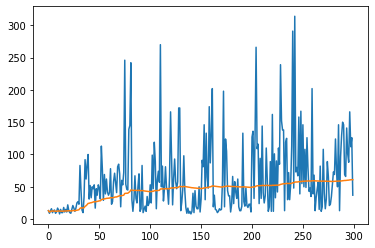

In [ ]:
plt.plot(ep_rewards)
plt.plot(avg_rewards[1:])
plt.show()

###References

In [ ]:
# https://github.com/abhisheksuran/Reinforcement_Learning/blob/master/PPO.ipynb
# https://arxiv.org/pdf/1707.06347.pdf
# https://www.youtube.com/watch?v=HR8kQMTO8bk&t=872s
# https://colab.research.google.com/drive/1MsRlEWRAk712AQPmoM9X9E6bNeHULRDb?usp=sharing#scrollTo=E4kMg80sbgrj

# GAES
# https://arxiv.org/pdf/1506.02438.pdf